In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import cv2
import random
import os
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
!unrar x '/content/drive/MyDrive/TASARIM_DERSI/Yazılımlar/datalar/ben_datasi1.rar' '/content'

##Data Augmentation

In [ ]:
print(len(os.listdir('/content/ben_datasi1/melanoma')))

350


In [ ]:
dir_path='/content/ben_datasi1/melanoma'
for i in os.listdir(dir_path):
    image=cv2.imread(dir_path+'/'+i)
    flipped = tf.image.flip_left_right(image) 
    new=np.array(image)
    %cd /content/ben_datasi1/melanoma
    cv2.imwrite('aug_'+i,new)

In [ ]:
print(len(os.listdir('/content/ben_datasi1/melanoma')))

700


In [ ]:
dir_path='/content/ben_datasi1/nevus'
for i in os.listdir(dir_path):
    image=cv2.imread(dir_path+'/'+i)
    flipped = tf.image.flip_left_right(image) 
    new=np.array(image)
    %cd /content/ben_datasi1/nevus
    cv2.imwrite('aug_'+i,new)

In [ ]:
print(len(os.listdir('/content/ben_datasi1/nevus')))

700


##Data Prepare

In [ ]:
data_dir = '/content/ben_datasi1'
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    color_mode = 'rgb',
    validation_split=0.2,
    subset='training',
    seed=123,
    batch_size=16,
    image_size=(img_height, img_width)
)

Found 1400 files belonging to 2 classes.
Using 1120 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    color_mode = 'rgb',
    validation_split=0.2,
    subset='validation',
    seed=123,
    batch_size=16,
    image_size=(img_height, img_width)
)

Found 92 files belonging to 2 classes.
Using 18 files for validation.


In [ ]:
class_names= train_ds.class_names
print(class_names)

['melanoma', 'nevus']


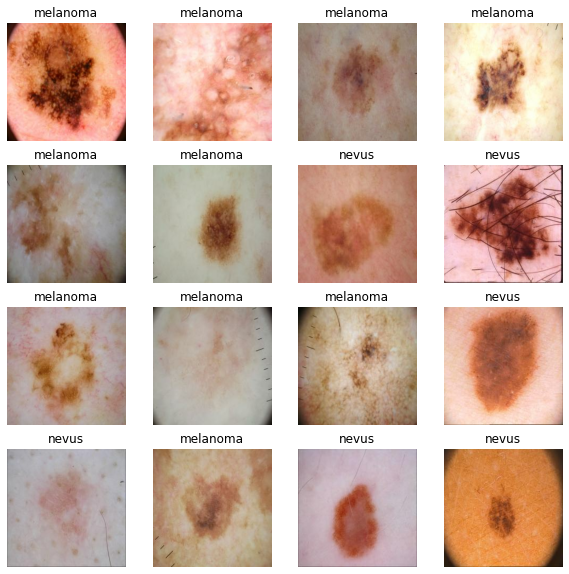

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 224, 224, 3)
(16,)


##model oluşturma

In [ ]:
base_model = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, input_shape=(224,224,3), weights='imagenet')

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
model = tf.keras.models.Sequential()

In [ ]:
model.add(tf.keras.layers.experimental.preprocessing.Rescaling((1./255)))
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))

In [ ]:
base_model.trainable=False

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [ ]:
epochs=15
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs) 

Epoch 1/15
70/70 [==============================] - 45s 166ms/step - loss: 0.8186 - accuracy: 0.6482 - val_loss: 0.5961 - val_accuracy: 0.6821
Epoch 2/15
70/70 [==============================] - 10s 140ms/step - loss: 0.5130 - accuracy: 0.7679 - val_loss: 0.4483 - val_accuracy: 0.8107
Epoch 3/15
70/70 [==============================] - 10s 139ms/step - loss: 0.4393 - accuracy: 0.8116 - val_loss: 0.3824 - val_accuracy: 0.8000
Epoch 4/15
70/70 [==============================] - 10s 139ms/step - loss: 0.3761 - accuracy: 0.8250 - val_loss: 0.3367 - val_accuracy: 0.8643
Epoch 5/15
70/70 [==============================] - 10s 140ms/step - loss: 0.3229 - accuracy: 0.8589 - val_loss: 0.2738 - val_accuracy: 0.9214
Epoch 6/15
70/70 [==============================] - 10s 140ms/step - loss: 0.2609 - accuracy: 0.8902 - val_loss: 0.2541 - val_accuracy: 0.9321
Epoch 7/15
70/70 [==============================] - 10s 140ms/step - loss: 0.2429 - accuracy: 0.9089 - val_loss: 0.2515 - val_accuracy: 0.9143

In [ ]:
model.save(f'resnet50_700image_15ep.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
model.save('/content/resnet50_700image_15ep.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


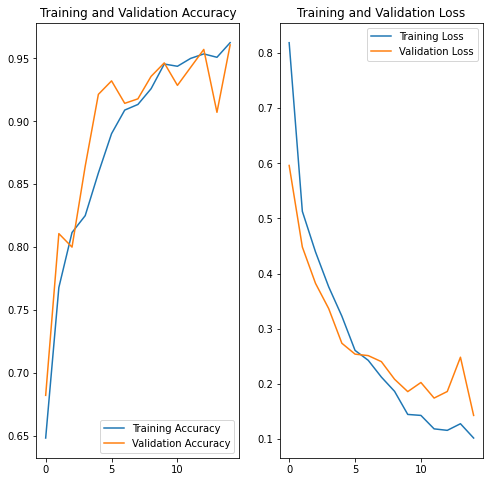

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Test

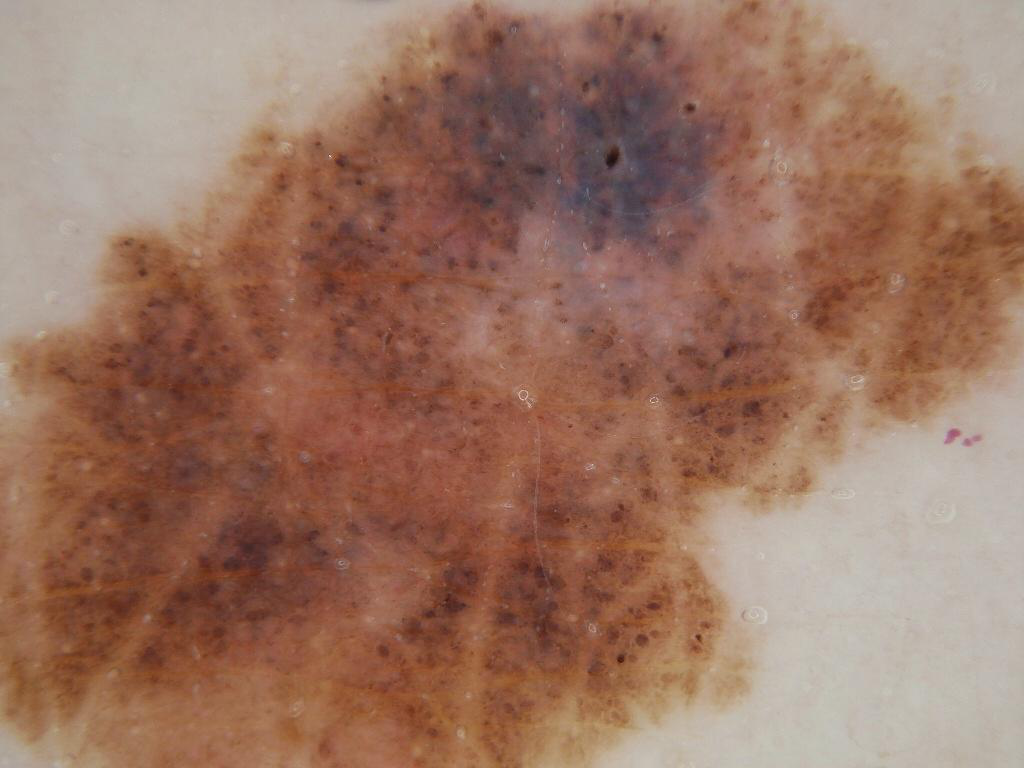

In [ ]:
img='/content/drive/MyDrive/TASARIM_DERSI/Yazılımlar/datalar/ISIC_0011185.jpg'
PIL.Image.open(img)

In [ ]:
img = tf.keras.preprocessing.image.load_img(img, target_size=(224,224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions =model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(f"This image most likely belongs to {class_names[np.argmax(score)]} with a {100 * np.max(score)} percent confidence.") 

This image most likely belongs to melanoma with a 71.40923142433167 percent confidence.


In [ ]:
!unrar x '/content/drive/MyDrive/TASARIM_DERSI/Yazılımlar/datalar/ben_test_datasi1.rar' '/content'

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/TASARIM_DERSI/Yazılımlar/modeller/resnet50_700image_15ep.h5')

In [ ]:
data_dir =  '/content/ben_test_datasi1'

In [ ]:
img_height = 224
img_width = 224
batch_size = 7

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    color_mode='rgb',
    seed=123,
    batch_size = batch_size,
    image_size=(img_height, img_width)
)

Found 14 files belonging to 2 classes.


In [ ]:
class_names1 = test_ds.class_names
print(class_names1)

['melanoma', 'nevus']


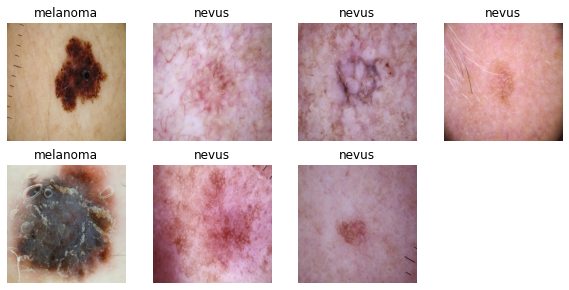

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(7):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8")) 
    plt.title(class_names1[labels[i]])
    plt.axis("off")

In [ ]:
list_predictions = []
list_labels = []

for image, lables in test_ds.as_numpy_iterator():
  for a in range(len(labels)):
    predictions= model.predict(image[a].reshape(1, 224, 224, 3))
    list_predictions.append(class_names1[np.argmax(predictions)])
    list_labels.append(class_names1[labels[a]])

In [ ]:
dogru = 0
yanlis = 0

for i in range(len(list_labels)):
  if list_labels[i]==list_predictions[i]:
    dogru+=1
  else:
    yanlis+=1
  
print('Dogru tahmin: ', dogru)
print('yanlis tahmin: ', yanlis)

Dogru tahmin:  9
yanlis tahmin:  5


In [ ]:
print('Accuarcy score: ',accuracy_score(list_labels,list_predictions))
print(classification_report(list_labels,list_predictions))

Accuarcy score:  0.6428571428571429
              precision    recall  f1-score   support

    melanoma       0.44      1.00      0.62         4
       nevus       1.00      0.50      0.67        10

    accuracy                           0.64        14
   macro avg       0.72      0.75      0.64        14
weighted avg       0.84      0.64      0.65        14

